# Embedding demo

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import itertools

import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

from config import SET_MAPPING
from utils import get_key

KEY = get_key("gemini")
assert len(KEY) > 0

In [3]:
cq_df = pd.read_csv("../data/bme_cq_measures.csv")
cqs = [cq for cq in cq_df["cq"].to_list() if cq is not None and len(cq) > 5]
print(f"Loaded {len(cqs)} CQs from {cq_df.shape[0]} rows")

Loaded 204 CQs from 204 rows


## Embedding extraction

In [ ]:
from google import genai
from google.genai import types

client = genai.Client(api_key=KEY)

In [ ]:
cq_list = cq_df["cq"].to_list()

Below computes Gemini embeddings for semantic similarity, but using a lower dim

In [ ]:
batch_size = 20
batches = [cq_list[i:i + batch_size] for i in range(0, len(cq_list), batch_size)]

for i, batch in enumerate(batches):
    print(f"Processing batch {i + 1}/{len(batches)}")
    # make sure to use the same model as the one used for training
    result = client.models.embed_content(
        model="gemini-embedding-exp-03-07",
        contents=batch,
        config=types.EmbedContentConfig(
            task_type="SEMANTIC_SIMILARITY",
            output_dimensionality=512,
        )
    )

    if i == 0:
        embeddings = result.embeddings
    else:
        embeddings = np.concatenate((embeddings, result.embeddings), axis=0)
    # add a small delay to avoid hitting the rate limit
    if i < len(batches) - 1:
        time.sleep(40)
        
assert len(embeddings) == len(cq_list), f"Expected {len(cq_list)} embeddings, got {len(embeddings)}"

# finally, let's dump the embeddings to a list of dictionaries with the cq, the set they belong to (from the dataframe) and the embedding
embeddings_list = []
for i, cq in enumerate(cq_list):
    embeddings_list.append({
        "cq": cq,
        "set": SET_MAPPING[cq_df.iloc[i]["set"]],
        "embedding": embeddings[i]
    })
# and save it to a pickle file

with open("../data/embeddings/cq_embeddings_gemini.pkl", "wb") as f:
    pickle.dump(embeddings_list, f)

# and let's also save the embeddings to a dataframe
embeddings_df = pd.DataFrame(embeddings_list)
embeddings_df.to_csv("../data/embeddings/cq_embeddings_gemini.csv", index=False)


... or simply load the Gemini embeddings

In [ ]:
# read the pickle file back
with open("../data/embeddings/cq_embeddings_gemini.pkl", "rb") as f:
    embeddings_list = pickle.load(f)
print(f"Loaded {len(embeddings_list)} embeddings from pickle file")

# a new list of dicts where 'embeddings' is transformed like this embeddings_list[0]['embedding'].values
embeddings_list = [
    {
        "cq": cq["cq"],
        "set": cq["set"],
        "embedding": np.array(cq["embedding"].values, dtype=np.float32)
    }
    for cq in embeddings_list
]

More standard approach: compute sentence-level BERT embeddings

In [ ]:
# Now let's repeat the extraction (without batching) using sentence bert (optimized for paraphrase detection)
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(cq_list, show_progress_bar=True, device='cpu')
# still keep cq and set in the embeddings_list for compatibility
assert len(embeddings) == len(cq_list)
embeddings_list = [
    {
        "cq": cq["cq"],
        "set": cq["set"],
        "embedding": np.array(embedding, dtype=np.float32)
    }
    for cq, embedding in zip(embeddings_list, embeddings)
]


# and save it to a pickle file
with open("../data/embeddings/cq_embeddings_sbert.pkl", "wb") as f:
    pickle.dump(embeddings, f)
# and let's also save the embeddings to a dataframe
embeddings_df = pd.DataFrame(embeddings_list)
# embeddings_df["embedding"] = embeddings.tolist()
embeddings_df.to_csv("../data/embeddings/cq_embeddings_sbert.csv", index=False)


... or load sentence-bert embeddings

In [4]:
# read the pickle file back
with open("../data/embeddings/cq_embeddings_sbert.pkl", "rb") as f:
    embeddings_list = pickle.load(f)
print(f"Loaded {len(embeddings_list)} embeddings from pickle file")

print(embeddings_list[0]["embedding"].shape)
# a new list of dicts where 'embeddings' is transformed like this embeddings_list[0]['embedding'].values

Loaded 204 embeddings from pickle file
(384,)


### Choose embeddings and visualise

In [5]:
# make a dataframe from the list of dicts
embeddings_df = pd.DataFrame(embeddings_list)
# make sure that the embedding column is a numpy array
embeddings_df["embedding"] = embeddings_df["embedding"].apply(lambda x: np.array(x, dtype=np.float32))

embeddings_df

,cq,set,embedding
0,Are there images of the item being used or cre...,HA-1,"[-0.037966345, 0.1271268, -0.06843685, 0.01755..."
1,When is a loaned item expected to be returned?,HA-1,"[-0.06904684, 0.018773405, 0.02862688, 0.01113..."
2,Is the artefact out for repair?,HA-1,"[-0.057996687, 0.032756947, 0.08512307, -0.014..."
3,What type of artist is Queen?,HA-1,"[0.056083027, -0.052669715, -0.0062504164, 0.0..."
4,What are the types of the artefacts that be di...,HA-1,"[0.015612866, 0.03678245, 0.019083804, -0.0131..."
...,...,...,...
199,How can the system represent the relationship ...,Gemini 2.5 Pro,"[-0.059628595, 0.050273385, -0.03298342, -0.05..."
200,How can the system represent the status of a l...,Gemini 2.5 Pro,"[-0.045141444, -0.004737289, -0.065197185, -0...."
201,What information about loaned artifacts should...,Gemini 2.5 Pro,"[-0.0127306245, 0.06263645, -0.039982565, -0.0..."
202,How does the system distinguish between artifa...,Gemini 2.5 Pro,"[-0.009339606, 0.06570279, -0.0056601954, -0.0..."


/Users/jacopodeberardinis/anaconda3/envs/bmenv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


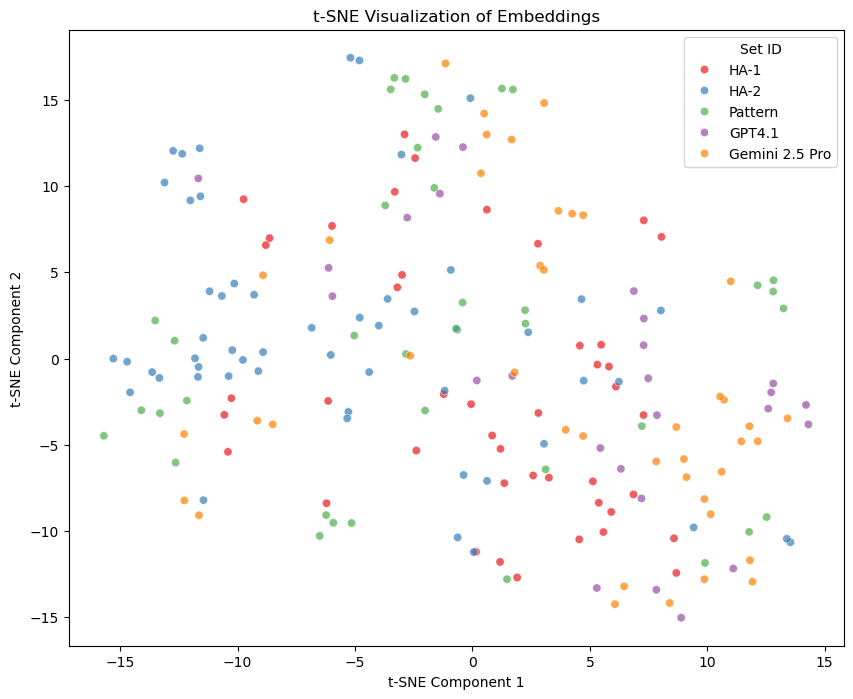

In [6]:
# Visualise embeddings # with t-SNE
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def visualize_embeddings_tsne(embeddings_df, perplexity=30, n_iter=1000):
    """
    Visualize embeddings using t-SNE.
    
    Parameters:
    - embeddings_df: DataFrame containing the embeddings and their corresponding sets.
    - set_mapping: Dictionary mapping set names to their IDs.
    - perplexity: Perplexity parameter for t-SNE.
    - n_iter: Number of iterations for t-SNE optimization.
    """
    
    # Extract embeddings and labels
    # from embedding column to a matrix where each row is an embedding in numpy
    
    embeddings = []
    for embedding in embeddings_df["embedding"]:
        # Convert the embedding from a list to a numpy array
        embeddings.append(np.array(embedding))
    embeddings = np.array(embeddings)
    labels = embeddings_df["set"]
    
    # Standardize the data
    scaler = StandardScaler()
    scaled_embeddings = scaler.fit_transform(embeddings)
    
    # Apply t-SNE
    tsne = TSNE(perplexity=perplexity, n_iter=n_iter, random_state=42)
    tsne_results = tsne.fit_transform(scaled_embeddings)
    
    # Create a DataFrame for visualization
    tsne_df = pd.DataFrame(tsne_results, columns=["x", "y"])
    tsne_df["label"] = labels
    
    # Plotting
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=tsne_df, x="x", y="y", hue="label", palette="Set1", alpha=0.7)
    plt.title("t-SNE Visualization of Embeddings")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend(title="Set ID")
    plt.show()
    
# Call the function to visualize embeddings using t-SNE
visualize_embeddings_tsne(embeddings_df, perplexity=30, n_iter=1000)

In [11]:
# --- Configuration ---
SIMILARITY_THRESHOLD = 0.75  # Threshold for defining novelty/sufficient coverage
N_PCA_COMPONENTS = 2         # For visualization (2D)
N_CLUSTERS_FOR_ENTROPY = 5   # Number of clusters for discrete entropy calculation

### 1. Individual measures

In [12]:
from embedding import get_set_data, calculate_internal_diversity, calculate_shannon_entropy_for_set

In [13]:
print("\n=== 1. Individual Set Analysis ===")
diversity_results_list = []
for set_name in SET_MAPPING.values():
    cqs, embeddings = get_set_data(embeddings_df, set_name, embed_dim=384)
    if embeddings.size == 0:
        print(f"\nNo data for set: {set_name}. Skipping.")
        diversity_results_list.append({
            "Set Name": set_name, "Num CQs": 0,
            "Avg Pairwise Cosine Sim (Mean ± Std)": "N/A",
            "Avg Dist to Centroid (Mean ± Std)": "N/A",
            f"Shannon Entropy (k={N_CLUSTERS_FOR_ENTROPY})": np.nan
        })
        continue

    diversity_metrics = calculate_internal_diversity(embeddings, set_name)
    shannon_ent = calculate_shannon_entropy_for_set(embeddings, set_name, N_CLUSTERS_FOR_ENTROPY)
    
    diversity_results_list.append({
        "Set Name": set_name,
        "Num CQs": diversity_metrics["num_cqs"],
        "Avg Pairwise Cosine Sim (Mean ± Std)": f"{diversity_metrics['avg_pairwise_cosine_similarity']:.3f} ± {diversity_metrics['std_pairwise_cosine_similarity']:.3f}" if not np.isnan(diversity_metrics['avg_pairwise_cosine_similarity']) else "N/A",
        "Avg Dist to Centroid (Mean ± Std)": f"{diversity_metrics['avg_dist_to_centroid']:.3f} ± {diversity_metrics['std_dist_to_centroid']:.3f}" if not np.isnan(diversity_metrics['avg_dist_to_centroid']) else "N/A",
        f"Shannon Entropy (k={N_CLUSTERS_FOR_ENTROPY})": f"{shannon_ent:.3f}" if not np.isnan(shannon_ent) else "N/A"
    })

diversity_df = pd.DataFrame(diversity_results_list)
print("\n--- Internal Diversity Metrics Table ---")
print(diversity_df.to_string())
print("\nLaTeX format for Internal Diversity Table:")
print(diversity_df.to_latex(index=False, escape=False, na_rep='N/A'))


=== 1. Individual Set Analysis ===

--- Internal Diversity of HA-1 ---
  Number of CQs: 44
  Avg Pairwise Cosine Similarity: 0.3101 (Std: 0.1573)
  Avg Euclidean Distance to Centroid: 0.8174 (Std: 0.0781)
  Shannon Entropy (k=5, bits): 2.1081

--- Internal Diversity of HA-2 ---
  Number of CQs: 54
  Avg Pairwise Cosine Similarity: 0.2655 (Std: 0.1674)
  Avg Euclidean Distance to Centroid: 0.8448 (Std: 0.0852)
  Shannon Entropy (k=5, bits): 2.0215

--- Internal Diversity of Pattern ---
  Number of CQs: 38
  Avg Pairwise Cosine Similarity: 0.1787 (Std: 0.1823)
  Avg Euclidean Distance to Centroid: 0.8936 (Std: 0.0353)
  Shannon Entropy (k=5, bits): 2.2292

--- Internal Diversity of GPT4.1 ---
  Number of CQs: 26
  Avg Pairwise Cosine Similarity: 0.3060 (Std: 0.1414)
  Avg Euclidean Distance to Centroid: 0.8150 (Std: 0.0555)
  Shannon Entropy (k=5, bits): 2.2610

--- Internal Diversity of Gemini 2.5 Pro ---
  Number of CQs: 42
  Avg Pairwise Cosine Similarity: 0.2870 (Std: 0.1817)
  Avg 

In [19]:
from embedding import calculate_centroid_similarity, analyze_set_coverage

# --- 2. Pairwise Set Comparison ---
print("\n=== 2. Pairwise Set Comparison ===")
pairwise_results_list = []
set_ids = list(SET_MAPPING.values())

for name1, name2 in itertools.combinations(set_ids, 2):

    cqs1, embeddings1 = get_set_data(embeddings_df, name1, embed_dim=384)
    num_cqs1 = len(cqs1)
    cqs2, embeddings2 = get_set_data(embeddings_df, name2, embed_dim=384)
    num_cqs2 = len(cqs2)

    if embeddings1.size == 0 or embeddings2.size == 0:
        print(f"\nSkipping comparison between {name1} and {name2} due to missing embeddings.")
        pairwise_results_list.append({
            "Comparison": f"{name1} vs {name2}", "Centroid Sim.": np.nan,
            f"Coverage {name1} by {name2} (%)": np.nan, f"Mean Max Sim ({name1} by {name2}) (Mean ± Std)": "N/A", f"Novelty {name1} w.r.t {name2} (%)": np.nan,
            f"Coverage {name2} by {name1} (%)": np.nan, f"Mean Max Sim ({name2} by {name1}) (Mean ± Std)": "N/A", f"Novelty {name2} w.r.t {name1} (%)": np.nan,
            "Bidirectional Coverage Proportion (%)": np.nan
        })
        continue

    print(f"\n--- Comparing '{name1}' and '{name2}' ---")
    
    centroid_sim = calculate_centroid_similarity(embeddings1, embeddings2)
    print(f"  Overall Centroid Similarity: {centroid_sim:.4f}")

    coverage_1_by_2 = analyze_set_coverage(cqs1, embeddings1, embeddings2, SIMILARITY_THRESHOLD, name1, name2)
    coverage_2_by_1 = analyze_set_coverage(cqs2, embeddings2, embeddings1, SIMILARITY_THRESHOLD, name2, name1)
    
    # Bidirectional Coverage Proportion
    if num_cqs1 + num_cqs2 > 0:
        bidirectional_coverage = (coverage_1_by_2["num_covered"] + coverage_2_by_1["num_covered"]) / (num_cqs1 + num_cqs2) * 100
    else:
        bidirectional_coverage = np.nan

    pairwise_results_list.append({
        "Comparison": f"{name1} vs {name2}",
        "Centroid Sim.": f"{centroid_sim:.3f}" if not np.isnan(centroid_sim) else "N/A",
        f"Coverage {name1} by {name2} (%)": f"{coverage_1_by_2['percentage_covered']:.1f}" if coverage_1_by_2 else "N/A",
        f"Mean Max Sim ({name1} by {name2}) (Mean ± Std)": f"{coverage_1_by_2['mean_max_similarity']:.3f} ± {coverage_1_by_2['std_max_similarity']:.3f}" if coverage_1_by_2 and not np.isnan(coverage_1_by_2['mean_max_similarity']) else "N/A",
        f"Novelty {name1} w.r.t {name2} (%)": f"{coverage_1_by_2['percentage_novel']:.1f}" if coverage_1_by_2 else "N/A",
        f"Coverage {name2} by {name1} (%)": f"{coverage_2_by_1['percentage_covered']:.1f}" if coverage_2_by_1 else "N/A",
        f"Mean Max Sim ({name2} by {name1}) (Mean ± Std)": f"{coverage_2_by_1['mean_max_similarity']:.3f} ± {coverage_2_by_1['std_max_similarity']:.3f}" if coverage_2_by_1 and not np.isnan(coverage_2_by_1['mean_max_similarity']) else "N/A",
        f"Novelty {name2} w.r.t {name1} (%)": f"{coverage_2_by_1['percentage_novel']:.1f}" if coverage_2_by_1 else "N/A",
        "Bidirectional Coverage Proportion (%)": f"{bidirectional_coverage:.1f}" if not np.isnan(bidirectional_coverage) else "N/A"
    })


=== 2. Pairwise Set Comparison ===

--- Comparing 'HA-1' and 'HA-2' ---
  Overall Centroid Similarity: 0.8199
  - Coverage of 'HA-1' by 'HA-2':
    Mean Max Similarity: 0.6231 (Std: 0.1478)
    Median Max Similarity: 0.6268
    CQs in 'HA-1' covered (sim >= 0.75): 9 (20.45%)
    Novel CQs in 'HA-1' (sim < 0.75): 35 (79.55%)
  - Coverage of 'HA-2' by 'HA-1':
    Mean Max Similarity: 0.5783 (Std: 0.1474)
    Median Max Similarity: 0.5558
    CQs in 'HA-2' covered (sim >= 0.75): 6 (11.11%)
    Novel CQs in 'HA-2' (sim < 0.75): 48 (88.89%)

--- Comparing 'HA-1' and 'Pattern' ---
  Overall Centroid Similarity: 0.8252
  - Coverage of 'HA-1' by 'Pattern':
    Mean Max Similarity: 0.6145 (Std: 0.1513)
    Median Max Similarity: 0.6170
    CQs in 'HA-1' covered (sim >= 0.75): 7 (15.91%)
    Novel CQs in 'HA-1' (sim < 0.75): 37 (84.09%)
  - Coverage of 'Pattern' by 'HA-1':
    Mean Max Similarity: 0.5669 (Std: 0.1587)
    Median Max Similarity: 0.5515
    CQs in 'Pattern' covered (sim >= 0.75):

In [18]:
pairwise_results_list

[{'Comparison': 'HA-1 vs HA-2',
  'Centroid Sim.': '0.820',
  'Coverage HA-1 by HA-2 (%)': '20.5',
  'Mean Max Sim (HA-1 by HA-2) (Mean ± Std)': '0.623 ± 0.148',
  'Novelty HA-1 w.r.t HA-2 (%)': '79.5',
  'Coverage HA-2 by HA-1 (%)': '11.1',
  'Mean Max Sim (HA-2 by HA-1) (Mean ± Std)': '0.578 ± 0.147',
  'Novelty HA-2 w.r.t HA-1 (%)': '88.9',
  'Bidirectional Coverage Proportion (%)': '15.3'},
 {'Comparison': 'HA-1 vs Pattern',
  'Centroid Sim.': '0.825',
  'Coverage HA-1 by Pattern (%)': '15.9',
  'Mean Max Sim (HA-1 by Pattern) (Mean ± Std)': '0.615 ± 0.151',
  'Novelty HA-1 w.r.t Pattern (%)': '84.1',
  'Coverage Pattern by HA-1 (%)': '13.2',
  'Mean Max Sim (Pattern by HA-1) (Mean ± Std)': '0.567 ± 0.159',
  'Novelty Pattern w.r.t HA-1 (%)': '86.8',
  'Bidirectional Coverage Proportion (%)': '14.6'},
 {'Comparison': 'HA-1 vs GPT4.1',
  'Centroid Sim.': '0.846',
  'Coverage HA-1 by GPT4.1 (%)': '9.1',
  'Mean Max Sim (HA-1 by GPT4.1) (Mean ± Std)': '0.557 ± 0.132',
  'Novelty HA-1 